# Train a Variational Auto-Encoder (VAE)

We use a variational auto-encoder (VAE) for the purpose of object detection.
Since we want to be able to classify 5 object classes, we use a VAE with 
6 latent variables (5 objects + background = 6 classes).
Input to the VAE are patches from the scene image.
After training, the latent variables should be mapped to the objects by means of calibration images.
For classification the trained VAE is moved over the test image in a sliding window-fashion. The 6 latent variables build a 6-dimensional map with one dimension per class. Each of these 6 maps can be interpreted as a heat-map for the corresponding class, allowing us to segment the corresponding object.

In [1]:
from breze.learn import sgvb
import climin.initialize
import climin.stops

from matplotlib import pyplot as plt
%matplotlib inline 
import numpy as np
import os

import theano
theano.config.compute_test_value = 'ignore'#'raise'

In [2]:
def scale_to_unit_interval(nd_arr, eps=1e-8):
    """ Return a copy of dn_arr with all values scaled between 0 and 1."""
    nd_arr = nd_arr.copy()
    nd_arr -= nd_arr.min()
    nd_arr *= 1.0/(nd_arr.max()+eps)
    return nd_arr


def tile_raster_images(images, image_shape, tile_shape, tile_spacing=(0, 0), 
                       scale_rows_to_unit_interval=True,
                       output_pixel_values=True):
    """ Transform an array, with one flattened image per row, into an array in
    which images are reshaped and layed out like tiles on a floor.
    
    This function is useful for visualizing datasets whose rows are images,
    and also columns of matrices for transforming those rows
    (such as the first layer of a neural net).
    Adapted from 'http://deeplearning.net/tutorial/utilities.html#how-to-plot'.
    
    :param images: a 2d numpy array in which every row is a flattened image.
    :param image_shape: tuple (height, widht) with the original shape of each 
    image.
    :param tile_shape: tuple (rows, columns) with the number of images to 
    tile.
    :param tile_spacing: tuple (hs, ws) with the vertical and horizontal pixel 
    spacing between the tiled images.
    :param output_pixel_values: if output should be pixel values (i.e., uint8
    values) or floats.
    :param scale_rows_to_unit_interval: if the values need to be scaled to 
    [0, 1] before being plotted or not.
    :returns: a numpy array suitable for viewing as an image.
    """
    
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2
    assert images.shape[1] == np.prod(image_shape)
    
    # The expression below can be re-written in a more C style as
    # follows :
    #
    # out_shape    = [0,0]
    # out_shape[0] = (img_shape[0]+tile_spacing[0])*tile_shape[0] -
    #                tile_spacing[0]
    # out_shape[1] = (img_shape[1]+tile_spacing[1])*tile_shape[1] -
    #                tile_spacing[1]
    out_shape = [(ishp + tsp)*tshp - tsp for ishp, tshp, tsp 
                 in zip(image_shape[:2], tile_shape, tile_spacing)]
    
    if len(image_shape) == 2:
        H, W = image_shape
        D = 1
    else:
        H, W, D = image_shape
    Hs, Ws = tile_spacing
    
    if output_pixel_values:
        dt = 'uint8'
    else:
        dt = images.dtype
    out_array = 255*np.ones(out_shape + [D, ], dtype=dt)
    
    for tile_row in xrange(tile_shape[0]):
            for tile_col in xrange(tile_shape[1]):
                if tile_row*tile_shape[1]+tile_col < images.shape[0]:
                    this_img = images[tile_row*tile_shape[1]+tile_col].reshape(image_shape)
                    if scale_rows_to_unit_interval:
                        this_img = scale_to_unit_interval(this_img)
                    # add the image to the corresponding position in the 
                    # output array
                    c = 1
                    if output_pixel_values:
                        c = 255
                    if len(image_shape) == 2:
                        this_img = this_img[:, :, np.newaxis]
                    out_array[
                        tile_row*(H+Hs):tile_row*(H+Hs)+H, 
                        tile_col*(W+Ws):tile_col*(W+Ws)+W
                    ] = c*this_img
    return out_array

## Load training set and validation set and visualize first 64 samples of each

In [3]:
if os.name == 'posix':
    code_dirname = os.path.join(u'/home', 'baxter', 'ros_ws', 'src')
elif os.name == 'nt':
    code_dirname = os.path.join(u'\\\srv-file.brml.tum.de', 'nthome', 
                                'mludersdorfer', 'reallyMyDocuments', 
                                'code')
else:
    print 'wtf?'

package_dirname = os.path.join(code_dirname, 'baxter_pick_and_place')
data_dirname = os.path.join(package_dirname, 'data', 
                            'synthetic_demo_data', 'vae')

In [4]:
patch_dims = (45, 45, 3)

### Training set

In [5]:
datafile = os.path.join(data_dirname, 'train.txt')
data = np.loadtxt(datafile, dtype='uint8', delimiter=' ')
noise = np.random.uniform(low=0.0, high=1.0, size=data.shape)
X = data + noise
np.random.shuffle(X)

### Normalize data using mean and standard deviation of training set

In [6]:
mean = X.mean(axis=0)
X -= mean
std = X.std(axis=0)
X /= std

### Validation set

In [7]:
datafile = os.path.join(data_dirname, 'val.txt')
data = np.loadtxt(datafile, dtype='uint8', delimiter=' ')
noise = np.random.uniform(low=0.0, high=1.0, size=data.shape)
VX = data + noise
np.random.shuffle(VX)

In [8]:
VX -= mean
VX /= std

### Visualize

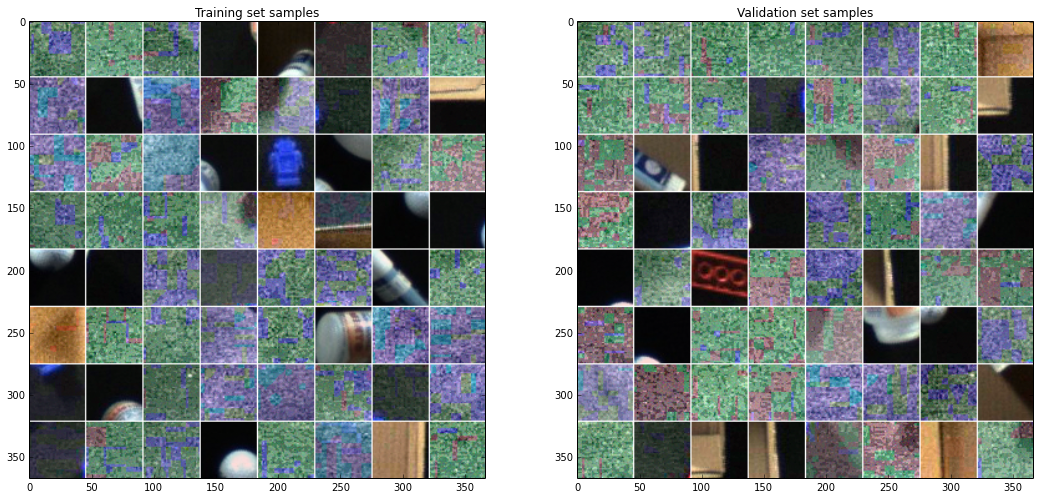

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

img = tile_raster_images((X[:64]), patch_dims, (8, 8), (1, 1))
axs[0].imshow(img)
axs[0].set_title("Training set samples")

img = tile_raster_images((VX[:64]), patch_dims, (8, 8), (1, 1))
axs[1].imshow(img)
axs[1].set_title("Validation set samples")

## Set up the VAE

In [10]:
batch_size = 200
#optimizer = 'rmsprop', {'step_rate': 1e-4, 'momentum': 0.95, 'decay': .95, 'offset': 1e-6}
#optimizer = 'adam', {'step_rate': .5, 'momentum': 0.9, 'decay': .95, 'offset': 1e-6}
optimizer = 'adam'#, {'step_rate': .1}

reload(sgvb)


class MyVAE(sgvb.VariationalAutoEncoder,
            sgvb.MlpGaussLatentVAEMixin, 
            sgvb.MlpGaussVisibleVAEMixin, 
            ):
    pass
kwargs = {}


# This is the number of random variables NOT the size of 
# the sufficient statistics for the random variables.
n_latents = 12
n_hidden = 512

m = MyVAE(X.shape[1], [n_hidden], n_latents, [n_hidden], ['rectifier'] * 1, ['rectifier'] * 1,
          optimizer=optimizer, batch_size=batch_size,
          **kwargs)

#m.exprs['loss'] += 0.001 * (m.parameters.enc_in_to_hidden ** 2).sum() / m.exprs['inpt'].shape[0]

climin.initialize.randomize_normal(m.parameters.data, 0, 1e-2)

#climin.initialize.sparsify_columns(m.parameters['enc_in_to_hidden'], 15)
#climin.initialize.sparsify_columns(m.parameters['enc_hidden_to_hidden_0'], 15)
#climin.initialize.sparsify_columns(m.parameters['dec_hidden_to_out'], 15)

#f_latent_mean = m.function(['inpt'], 'latent_mean')
#f_sample = m.function([('gen', 'layer-0-inpt')], 'output')
#f_recons = m.function(['inpt'], 'output')

In [13]:
m.estimate_nll(X[:10].astype('float32'))

14797747.489124248

## Train the VAE

In [14]:
max_passes = 250
max_iter = max_passes * X.shape[0] / batch_size
n_report = X.shape[0] / batch_size

stop = climin.stops.AfterNIterations(max_iter)
pause = climin.stops.ModuloNIterations(n_report)

for i, info in enumerate(m.powerfit((X,), (VX,), stop, pause)):
    print i, info['loss'], info['val_loss']

0 9418.63 10835.0
1 3667.74 4457.88
2 1061.78 2260.73
3 -1392.44 -283.722
4 -2995.7 -2005.83
5 -3557.38 -2708.15
6 -4303.99 -3421.96
7 -4753.79 -3902.8
8 -5171.3 -4348.43
9 -5313.06 -4468.8
10 -5617.41 -4822.48
11 -5962.55 -5194.93
12 -6165.69 -5408.63
13 -6226.63 -5512.57
14 85673.9 89969.0
15 88655.3 85319.8
16 85602.5 84189.7
17 82814.8 79460.9
18 70588.5 68615.8
19 66350.3 64330.6
20 65009.3 63227.3
21 57161.1 55807.6
22 47104.9 46019.3
23 84935.7 81581.0
24 88168.7 84634.7
25 110850.0 107393.0
26 97612.5 94484.7
27 83504.4 81499.3
28 106515.0 105036.0
29 121562.0 117571.0
30 121966.0 117952.0
31 100916.0 97972.9
32 81189.7 78537.9
33 151681.0 145633.0
34 199151.0 194338.0
35 279748.0 268485.0
36 256529.0 245757.0
37 222967.0 212171.0
38 198706.0 190557.0
39 198675.0 193213.0
40 197323.0 193378.0
41 177205.0 170290.0
42 255328.0 249926.0
43 360567.0 366709.0
44 363484.0 343293.0
45 355520.0 340460.0
46 386853.0 370588.0
47 368730.0 354079.0
48 371993.0 354748.0
49 360391.0 344353.0

\\srv-file.brml.tum.de\nthome\mludersdorfer\AppData\Roaming\Python\Python27\site-packages\climin\util.py:150: UserWarning: Argument named f is not expected by <class 'climin.adam.Adam'>
  % (i, klass))


In [15]:
m.parameters.data[...] = info['best_pars']

## Have a look at the generative ~ and reconstruction model

In [16]:
f_sample = m.function([m.recog_sample], m.vae.gen.sample())
f_recons = m.function(['inpt'], m.vae.gen.sample())

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


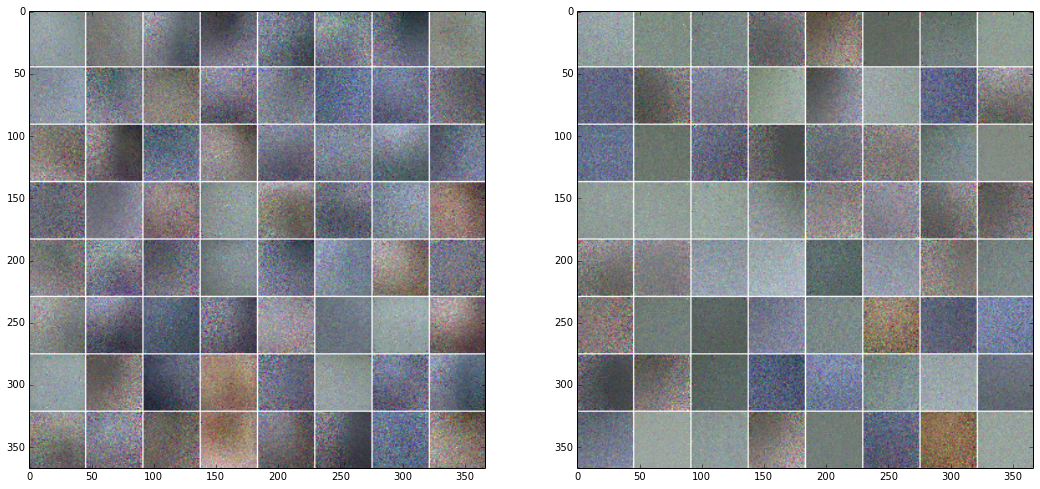

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

S = f_sample(np.random.standard_normal(size=(64, m.n_latent)).astype('float32'))
img = tile_raster_images(S, patch_dims, (8, 8), (1, 1))
axs[0].imshow(img)

R = f_recons(X[:64].astype('float32'))
img = tile_raster_images(R, patch_dims, (8, 8), (1, 1))

axs[1].imshow(img)

## Have a look at the filters

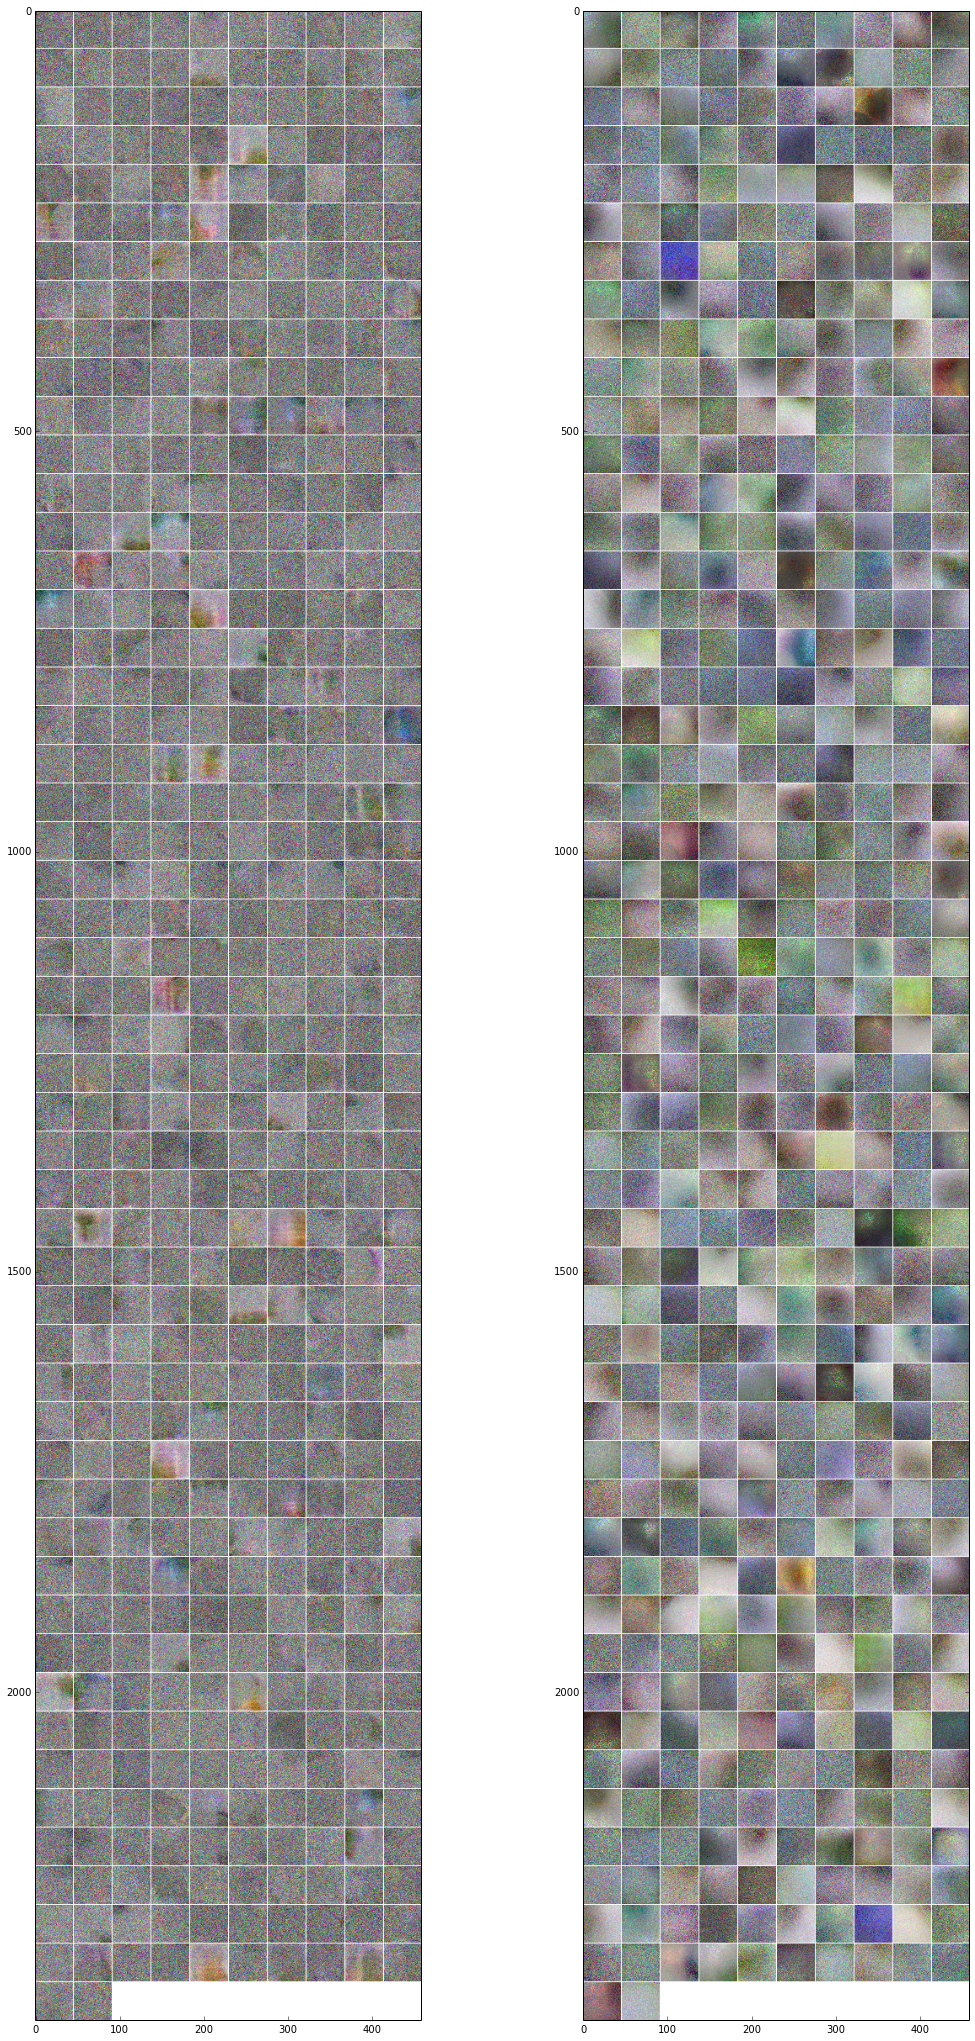

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(18, 36))
img = tile_raster_images(m.parameters[m.vae.recog.mlp.layers[0].weights].T[:, :X.shape[1]], patch_dims, (52, 10), (1, 1))
axs[0].imshow(img)

img = tile_raster_images(m.parameters[m.vae.gen.mlp.layers[-1].weights][:, :X.shape[1]], patch_dims, (52, 10), (1, 1))
axs[1].imshow(img)

## Visualize latent variables

In [20]:
f_L = m.function([m.vae.inpt], m.vae.recog.stt)

In [21]:
L = f_L(X.astype('float32'))  # contains n_latents means and n_latents variances for X.shape[0] samples

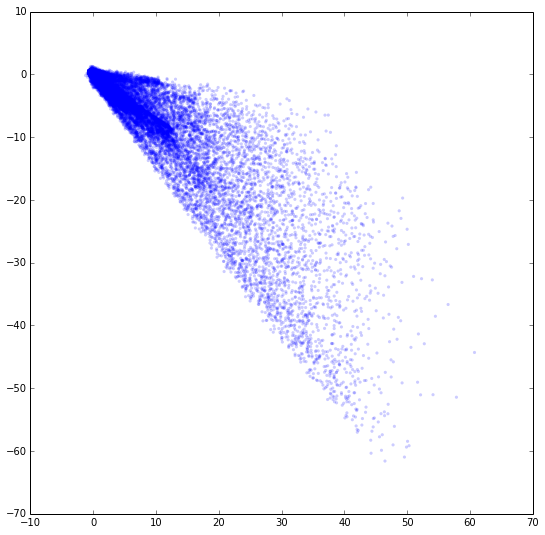

In [22]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.scatter(L[:, 0], L[:, 1], lw=0, s=10, alpha=.2)

### Test image

In [23]:
datafile = os.path.join(data_dirname, 'test_00.txt')
data = np.loadtxt(datafile, dtype='uint8', delimiter=' ')
noise = np.random.uniform(low=0.0, high=1.0, size=data.shape)
TX = data + noise

In [24]:
TX -= mean
TX /= std

In [25]:
TL = f_L(TX.astype('float32'))  # contains n_latents means and n_latents variances for TX.shape[0] samples
print TL.shape

(897L, 24L)


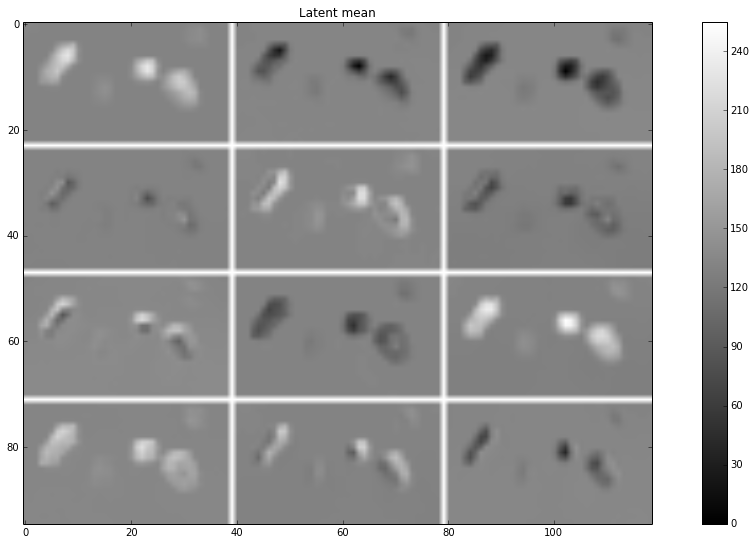

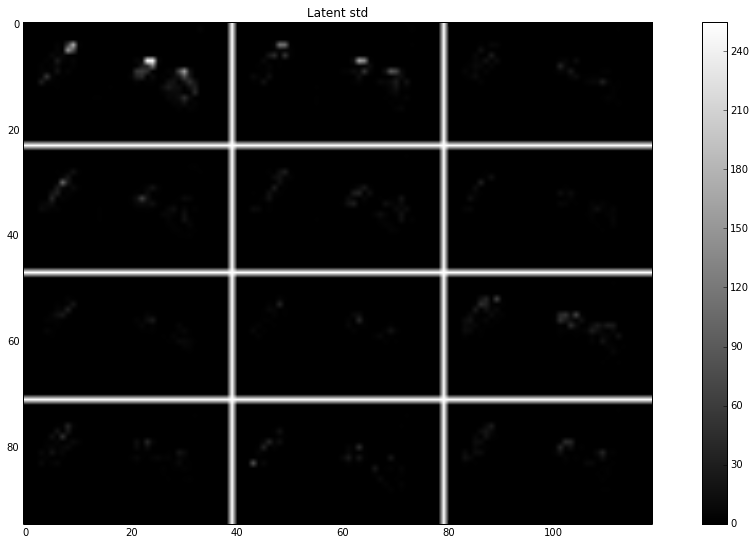

In [26]:
px = 39
py = 23

fig, ax = plt.subplots(1, 1, figsize=(18, 9))
latent_mean = scale_to_unit_interval(TL[:, :n_latents])
heatmap_mean = tile_raster_images(latent_mean.T, (py, px), (4, 3), (1, 1), 
                                  scale_rows_to_unit_interval=False).squeeze()
img = ax.imshow(heatmap_mean, cmap=plt.get_cmap('gray'))
plt.colorbar(img)
ax.set_title("Latent mean")

fig, ax = plt.subplots(1, 1, figsize=(18, 9))
latent_std = scale_to_unit_interval(TL[:, n_latents:])
heatmap_std = tile_raster_images(latent_std.T, (py, px), (4, 3), (1, 1), 
                                 scale_rows_to_unit_interval=False).squeeze()
img = ax.imshow(heatmap_std, cmap=plt.get_cmap('gray'))
plt.colorbar(img)
ax.set_title("Latent std")